<a href="https://colab.research.google.com/github/abhinsuresh/MLTSA_ASuresh/blob/master/HW9/HW9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import pylab as pl

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import keras
from keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [0]:
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/fbb.mplstyle")
mpl.style.use('default')

In [6]:
from google.colab import drive

drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
cd gdrive/My\ Drive

/content/gdrive/My Drive


In [0]:
mkdir PLAsTiCC

In [8]:
cd PLAsTiCC

/content/gdrive/My Drive/PLAsTiCC


#Data Acquisition

In [0]:
!wget https://zenodo.org/record/2539456/files/plasticc_train_lightcurves.csv.gz

In [0]:
lcvs = pd.read_csv('plasticc_train_lightcurves.csv.gz')

In [10]:
lcvs.shape

(1421705, 6)

In [0]:
lcvs = lcvs[:40000]

In [85]:
lcvs.shape

(40000, 6)

In [14]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [15]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [16]:
# limited objects in my dataset
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".\
      format(objects.shape[0]))

There are 121 astrophysical simulated objects in my dataset


In [0]:
def gaussian_process(mjd, flux):

  #normalizing the data
  mjd_norm = (mjd - mjd.mean()) / mjd.std()
  flux_norm = (flux - flux.mean()) / flux.std()
  #initating the gaussian process
  kernel = RBF(10, (1e-2, 1e2))
  gpreg = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, alpha=.3)
  gpreg.fit(mjd_norm.reshape(-1, 1), flux_norm)
  mjd_std = np.linspace((0 - mjd.mean()) / mjd.std(), (900 - mjd.mean()) / mjd.std())
  flux_std, sigma = gpreg.predict(mjd_std.reshape(-1, 1), return_std=True)
  return mjd_std, flux_std

In [0]:
import warnings

warnings.simplefilter("ignore", UserWarning)

In [19]:
# example of gaussian unifrom interavl process
mjd = lcvs[lcvs.object_id == 615][lcvs.passband == 0]['mjd'].to_numpy()
mjd = mjd - mjd[0]
flux = lcvs[lcvs.object_id == 615][lcvs.passband == 0]['flux'].to_numpy()

mjd_std, flux_std = gaussian_process(mjd, flux)
print(mjd[1] - mjd[0])
print(mjd[2] - mjd[1])
print(mjd_std[1] - mjd_std[0])
print(mjd_std[2] - mjd_std[1])

0.9515000000028522
0.9978999999948428
0.06681594074132358
0.0668159407413238


In [23]:
type(bands)
bands = numpy.sort(bands)
bands
type(lcvs.object_id.unique())

numpy.ndarray

In [0]:
mjd_ls = []
flux_ls = []
object_ids = []
passbands = []

for obj in lcvs.object_id.unique():
    for band in bands:
        mjd = lcvs[lcvs.object_id == obj]\
              [lcvs.passband == band]['mjd'].to_numpy()
        mjd = mjd - mjd[0]  
        flux = lcvs[lcvs.object_id == obj]\
                   [lcvs.passband == band]['flux'].to_numpy()

        mjd_std, flux_std = gaussian_process(mjd, flux)        
        mjd_ls.append(mjd_std)
        flux_ls.append(flux_std)
        object_ids.append(np.ones(len(mjd_std)) * obj)
        passbands.append(np.ones(len(mjd_std)) * band)

In [31]:
100//2

50

In [0]:
mjd_ar = np.array(mjd_ls)
flux_ar = np.array(flux_ls)
object_ar = np.array(object_ids)

In [0]:
gpdata = pd.DataFrame(flux_ar, index=object_ar[:, 0])

In [41]:
gpdata.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
615.0,0.291382,-0.000005,-0.133199,-1.021835,0.000050,5.462512e-28,2.289755e-70,3.904597e-132,2.720645e-213,7.748889e-314,0.000000e+00,-2.328870e-272,-1.997187e-179,-7.001321e-106,-1.003295e-51,-5.877132e-17,-1.407310e-01,-7.579096e-03,1.761645e-01,-7.045578e-04,-0.002614,-0.370116,0.059255,-0.009065,1.282418,-0.000001,-2.475999e-31,-1.687587e-75,-4.690395e-139,-5.327855e-222,0.000000e+00,0.000000e+00,1.130764e-245,6.780128e-158,1.662108e-89,1.668508e-40,6.974726e-11,1.016742e+00,1.707259e-02,9.719586e-04,0.829648,-0.001603,-0.624788,-0.731079,0.000483,7.085433e-25,7.633282e-65,3.550317e-124,6.782454e-203,5.298788e-301
615.0,-0.718862,-0.663721,0.065575,0.097258,-0.002082,-8.597749e-01,3.453603e-01,-2.814191e-02,-2.515899e-03,-4.293595e-19,-1.036030e-49,-3.574091e-95,-1.762871e-155,-1.243190e-230,-1.691626e-300,-1.303262e-213,-1.435559e-141,-2.260853e-84,-5.090790e-42,-1.638929e-14,-0.075439,-0.000497,-0.600872,-0.230182,0.283902,-0.511581,9.341887e-01,1.075892e+00,5.238986e-06,4.248947e-26,4.926940e-61,8.168363e-111,1.936220e-175,6.561999e-255,2.359569e-294,1.512147e-208,1.385533e-137,1.815105e-81,3.399713e-40,9.071645e-14,0.003065,0.138575,0.009331,0.810259,-0.033232,-4.136983e-01,2.901391e-01,-3.004456e-01,7.713729e-02,1.296345e-15
615.0,-0.854611,-0.848461,0.030248,-0.097178,-0.001956,-7.164304e-01,1.098730e-01,-7.848371e-02,-2.901322e-03,-4.914740e-19,-1.185880e-49,-4.091074e-95,-2.017887e-155,-1.423047e-230,-2.063814e-300,-1.589979e-213,-1.751360e-141,-2.758178e-84,-6.210580e-42,-1.999424e-14,-0.092032,-0.000606,-0.267449,-0.196088,0.446397,-0.162797,7.935305e-01,1.000462e+00,4.945422e-06,4.010873e-26,4.650904e-61,7.710790e-111,1.827777e-175,6.194563e-255,-2.312794e-295,-1.481873e-209,-1.357525e-138,-1.778066e-82,-3.330243e-41,-9.254126e-15,-0.036175,0.263286,0.008620,0.657697,-0.027583,-1.168991e-01,1.134104e-01,-2.925788e-01,5.630348e-02,9.244305e-16
615.0,-0.943144,-0.980328,-0.030701,-0.311575,-0.001747,-3.766878e-01,-1.306783e-01,-1.394527e-01,-3.241874e-03,-5.452521e-19,-1.315349e-49,-4.536819e-95,-2.237295e-155,-1.577453e-230,-2.307658e-300,-1.777879e-213,-1.958368e-141,-3.084236e-84,-6.944840e-42,-2.235827e-14,-0.102914,-0.000677,0.169431,-0.140231,0.602266,0.054909,6.227322e-01,9.071842e-01,4.569794e-06,3.706209e-26,4.297585e-61,7.124926e-111,1.688875e-175,5.723686e-255,-4.484559e-294,-2.873984e-208,-2.633359e-137,-3.449826e-81,-6.461725e-40,-1.733447e-13,-0.095390,0.316130,0.007392,0.481396,-0.016647,3.545735e-01,-1.074196e-01,-3.002762e-01,3.454116e-02,5.438086e-16
615.0,-0.992021,-1.101487,-0.123549,-0.626345,-0.001095,2.806021e-01,-3.505666e-01,-2.582527e-01,-3.431301e-03,-6.707034e-19,-2.191797e-49,-1.181852e-94,-1.051465e-154,-1.543459e-229,-4.369993e-299,-1.468019e-212,-8.136750e-141,-7.441133e-84,-1.122783e-41,-2.795253e-14,-0.114819,-0.000778,0.649586,0.078494,0.724846,0.282273,2.805324e-01,7.299097e-01,4.211289e-06,4.179275e-26,6.843141e-61,1.848752e-110,8.240822e-175,6.060815e-254,-1.416948e-292,-4.000218e-207,-1.863297e-136,-1.432019e-80,-1.815875e-39,-3.802052e-13,-0.155703,0.345515,0.004975,-0.014090,0.008036,8.853445e-01,-4.588400e-01,-3.178153e-01,2.003118e-02,3.382788e-16


In [0]:
X_train, X_test, y_train, y_test = train_test_split(gpdata, gpdata, test_size=0.2, random_state=32)

In [43]:
X_train.shape

(580, 50)

In [0]:
def create_model(input_dim=50):
  model = Sequential()
  model.add(Dense(50, activation='relu', input_dim=50))
  model.add(Dense(25, activation='relu'))
  model.add(Dense(5, activation='relu'))
  model.add(Dense(25, activation='relu'))
  model.add(Dense(50, activation='relu'))
  model.compile(optimizer='adamax', loss='mse', metrics=['mae', 'acc'])
  return model
model = create_model()

In [47]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 130       
_________________________________________________________________
dense_4 (Dense)              (None, 25)                150       
_________________________________________________________________
dense_5 (Dense)              (None, 50)                1300      
Total params: 5,405
Trainable params: 5,405
Non-trainable params: 0
_________________________________________________________________
None


### This model is choosen with 50 layers downsized to 5 layers in steps of two 

In [0]:
history = model.fit(X_train.values, y_train.values, epochs=10000, batch_size=32, verbose=1)
model.save("hw9model10000.h5")

In [0]:
model = keras.models.load_model('hw9model10000.h5')

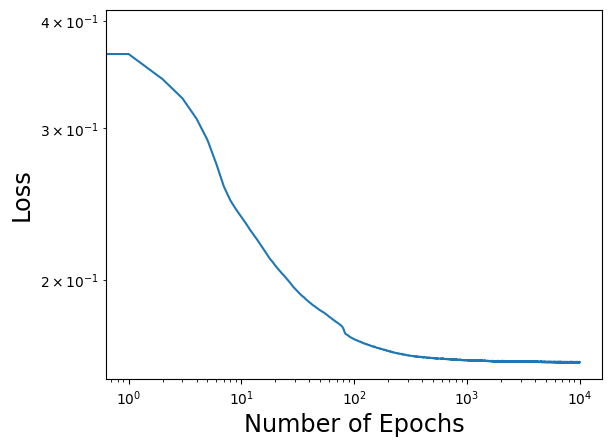

In [49]:
plt.plot(np.array(history.history['loss']))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Epochs', fontsize='xx-large')
plt.ylabel('Loss', fontsize='xx-large');

## Here I can see my loss is saturating to a low value, it can be considered as good number of epochs for fitting and is not going to overfitting

In [0]:
y_pred = model.predict(X_test)

In [54]:
# Create encoder to extract the bottleneck features from the model
encoderforbot = Model(model.input, model.layers[-3].output)
encoderforbot_predict = encoderforbot.predict(flux_ar)
encoderforbot_predict.shape

(726, 5)

In [55]:
encoder_features = pd.DataFrame(encoderforbot_predict, columns=['enc{0}'.format(i) for i in range(encoderforbot_predict.shape[1])])
encoder_features.head()

,enc0,enc1,enc2,enc3,enc4
0,3.551936,3.584672,4.268472,5.197043,1.539078
1,2.555055,2.550650,0.000000,0.751464,2.033255
2,3.120932,2.775256,1.262978,1.449848,1.875989
3,4.157471,3.477322,2.161210,2.584683,2.346682
4,6.120227,5.077867,3.338950,4.231472,3.542426


In [0]:
!wget https://zenodo.org/record/2539456/files/plasticc_train_metadata.csv.gz

In [88]:
metadata = pd.read_csv("plasticc_train_metadata.csv.gz")
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,92,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,88,1,1.817,45.703,0.000,0.0,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,42,2,0.233,40.328,0.004,4.5,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,90,1,0.301,40.969,-0.004,257.7,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,90,1,0.193,39.866,-0.002,-368.8,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
metadata.columns

Index(['object_id', 'ra', 'decl', 'ddf_bool', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target',
       'true_target', 'true_submodel', 'true_z', 'true_distmod',
       'true_lensdmu', 'true_vpec', 'true_rv', 'true_av', 'true_peakmjd',
       'libid_cadence', 'tflux_u', 'tflux_g', 'tflux_r', 'tflux_i', 'tflux_z',
       'tflux_y'],
      dtype='object')

In [89]:
print("The metadata dataset contains more information for each time series: \
      (time-series, columns)",
      metadata.shape)

The metadata dataset contains more information for each time series:       (time-series, columns) (7848, 26)


In [0]:
norm_band = Normalize(vmin=bands.min(), vmax=bands.max())

### Feature Extraction

1. Extraction mean and standard deviation of the original lightcurve

In [0]:
means = lcvs.groupby(["object_id", "passband"])[["flux"]].mean()
stds = lcvs.groupby(["object_id", "passband"])[["flux"]].std()

In [0]:
features = means.rename({"flux": "mean"}, axis=1).\
                  merge(stds.rename({"flux": "std"}, axis=1), 
                        left_index=True, right_index=True)

2. Heigher order moments m1 and m2

In [0]:
from scipy import stats 
def m2_get(x):
    return stats.moment(x, moment = 2)
def m3_get(x):
    return stats.moment(x, moment = 3)
    
m2 = lcvs.groupby(["object_id", "passband"])["flux"].apply(m2_get)
m3 = lcvs.groupby(["object_id", "passband"])["flux"].apply(m3_get)

In [0]:
features = features.merge(pd.DataFrame(m2).rename({"flux":"m2"}, axis=1), 
                          left_index=True, right_index=True)
features = features.merge(pd.DataFrame(m2).rename({"flux":"m3"}, axis=1), 
                          left_index=True, right_index=True)

3. Max and Min values

In [0]:
maxs = lcvs.groupby(["object_id", "passband"])["flux"].max()
mins = lcvs.groupby(["object_id", "passband"])["flux"].min()

In [0]:
features = features.merge(pd.DataFrame(maxs).rename({"flux":"maxs"}, axis=1), 
                          left_index=True, right_index=True)
features = features.merge(pd.DataFrame(mins).rename({"flux":"mins"}, axis=1), 
                          left_index=True, right_index=True)

4. Normalizing the original lightcurve

In [0]:
# normalize each LC this is very slow. can you make  it faster?
def normed(df):
   return (df - df.mean())/df.std()
       
lcvs['fluxnormed'] = lcvs.groupby(["object_id", "passband"])[['flux']].\
                                  apply(normed)
lcvs['fluxerrnormed'] = lcvs.groupby(["object_id", "passband"])[['flux_err']].\
                                  apply(normed)

5. Extraction of median and line fit parameters from normalized lightcurve : giving the center of mass

In [0]:
median = lcvs.groupby(["object_id", "passband"])[["fluxnormed"]].median()
#stds = lcvs.groupby(["object_id", "passband"])[["flux"]].std()

In [0]:
features = features.merge(median.rename({"fluxnormed": "median"}, axis=1), 
                        left_index=True, right_index=True)

6. Line fit parameters of normalized lightcurve

In [0]:
def slope(x):
    pars = np.polyfit(range(len(x)), x["fluxnormed"].values, 1)
    return pars[0]
def intercept(x):
    pars = np.polyfit(range(len(x)), x["fluxnormed"].values, 1)
    return pars[1]  

features['slope'] = lcvs.groupby(["object_id", "passband"]).\
                                      apply(slope).to_frame()
features['intercept'] = lcvs.groupby(["object_id", "passband"]).\
                                      apply(intercept).to_frame()

7. Quadratic fit parameters of the normalized lightcurve

In [100]:
from statsmodels.formula.api import ols
def quadfit(x):
    x['t'] = x.mjd - x.iloc[0].mjd
    mod1 = ols(formula='fluxnormed~t + 1', data=x).fit()
    mod2 = ols(formula='fluxnormed~pow(t, 2) + t + 1', data=x).fit()
    
    pars = mod2.llf, mod1.llf, np.sign(mod2.params[1])
    return pars
ols = lcvs.groupby(["object_id", "passband"]).apply(quadfit)

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [0]:
ll1 = [x[0] for x in ols.values[:]]
ll2 = [x[1] for x in ols.values[:]]
ll3 = [x[2] for x in ols.values[:]]

In [0]:
features["ll1"] = ll1
features["ll2"] = ll2
features["ll3"] = ll3

In [73]:
features.shape

(726, 12)

In [74]:
features.head()

mean         std  ...        ll2  ll3
object_id passband                          ...                
615       0          -3.254554   83.944735  ... -88.218652 -1.0
          1        -385.699911  601.787302  ... -80.869998 -1.0
          2        -134.146566  455.121346  ... -80.109763 -1.0
          3        -121.103501  335.425053  ... -79.290039 -1.0
          4         -55.954592  291.803449  ... -78.480261 -1.0

[5 rows x 12 columns]

In [0]:
allfeatures = features.reset_index().set_index(['object_id','passband']).stack(
    ).unstack([1,2])

In [76]:
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,92,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,88,1,1.817,45.703,0.000,0.0,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,42,2,0.233,40.328,0.004,4.5,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,90,1,0.301,40.969,-0.004,257.7,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,90,1,0.193,39.866,-0.002,-368.8,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


8. Adding features from metadata

In [77]:
allfeatures = allfeatures.merge(metadata[["object_id", "decl", "ddf_bool", \
                                          "hostgal_photoz",\
                                          "hostgal_photoz_err", "target"]], \
                                on=['object_id']).drop("object_id", axis=1)
allfeatures.head()

,"(0, mean)","(0, std)","(0, m2)","(0, m3)","(0, maxs)","(0, mins)","(0, median)","(0, slope)","(0, intercept)","(0, ll1)","(0, ll2)","(0, ll3)","(1, mean)","(1, std)","(1, m2)","(1, m3)","(1, maxs)","(1, mins)","(1, median)","(1, slope)","(1, intercept)","(1, ll1)","(1, ll2)","(1, ll3)","(2, mean)","(2, std)","(2, m2)","(2, m3)","(2, maxs)","(2, mins)","(2, median)","(2, slope)","(2, intercept)","(2, ll1)","(2, ll2)","(2, ll3)","(3, mean)","(3, std)","(3, m2)","(3, m3)","(3, maxs)","(3, mins)","(3, median)","(3, slope)","(3, intercept)","(3, ll1)","(3, ll2)","(3, ll3)","(4, mean)","(4, std)","(4, m2)","(4, m3)","(4, maxs)","(4, mins)","(4, median)","(4, slope)","(4, intercept)","(4, ll1)","(4, ll2)","(4, ll3)","(5, mean)","(5, std)","(5, m2)","(5, m3)","(5, maxs)","(5, mins)","(5, median)","(5, slope)","(5, intercept)","(5, ll1)","(5, ll2)","(5, ll3)",decl,ddf_bool,hostgal_photoz,hostgal_photoz_err,target
0,-3.254554,83.944735,6934.865833,6934.865833,125.182808,-116.913223,-0.080537,0.005676,-0.175947,-84.013092,-88.218652,-1.0,-385.699911,601.787302,355904.026224,355904.026224,660.626343,-1100.440063,-0.170090,0.014032,-0.399902,-80.867915,-80.869998,-1.0,-134.146566,455.121346,203564.138816,203564.138816,611.984558,-681.858887,-0.289021,0.017676,-0.503760,-80.092803,-80.109763,-1.0,-121.103501,335.425053,110570.138947,110570.138947,445.737061,-530.644592,-0.122434,0.020475,-0.583524,-79.226482,-79.290039,-1.0,-55.954592,291.803449,83681.162283,83681.162283,381.953735,-422.184509,-0.163078,0.022343,-0.636786,-78.160027,-78.480261,-1.0,-47.449847,294.779522,85370.493377,85370.493377,378.188141,-422.815094,-0.129163,0.021319,-0.596932,-76.917754,-77.386461,-1.0,-61.9438,1,0.000,0.000,92
1,-2.720398,7.113509,49.879128,49.879128,14.509829,-14.735178,-0.052914,-0.041433,1.429423,-45.801483,-49.801325,-1.0,-1.019804,5.712334,32.048070,32.048070,9.129021,-11.715749,0.080189,-0.051648,1.420320,-36.052358,-38.161170,-1.0,-0.794238,5.770738,32.706748,32.706748,10.529041,-10.067919,0.117188,-0.053887,1.481892,-34.410798,-35.611095,-1.0,-0.986966,6.450413,40.864832,40.864832,11.330316,-12.394593,0.141552,-0.050983,1.402038,-38.701863,-41.302700,-1.0,-0.900262,6.406989,40.316483,40.316483,9.827934,-12.286801,0.016870,-0.050464,1.387765,-44.424807,-44.870314,-1.0,-1.794175,7.094073,49.427194,49.427194,14.770886,-14.211164,-0.094281,-0.037903,1.042343,-65.167686,-65.424297,-1.0,-27.7844,1,1.627,0.255,88
2,-0.048080,1.828872,3.298318,3.298318,5.942166,-3.459960,0.039463,-0.001798,0.063840,-101.249926,-101.606902,-1.0,0.141057,1.807229,3.203266,3.203266,5.693109,-3.393080,0.016754,0.003167,-0.080770,-72.910038,-73.012277,-1.0,2.400870,5.559483,30.313471,30.313471,20.994711,-2.848838,-0.343392,0.026905,-0.686084,-63.777334,-65.193298,1.0,3.236164,8.191987,65.818099,65.818099,33.572102,-5.435799,-0.314425,0.024491,-0.624531,-66.369632,-66.683538,1.0,4.308728,10.710344,112.462234,112.462234,41.159981,-5.836310,-0.308522,0.022552,-0.563811,-65.239486,-66.161110,1.0,4.539396,13.332758,174.276892,174.276892,47.310059,-19.159811,-0.149763,0.019612,-0.490299,-66.518080,-67.853917,1.0,-6.5796,1,0.226,0.016,42
3,1.797523,4.374445,18.869993,18.869993,18.014029,-3.874349,-0.169349,-0.013089,0.464675,-88.423048,-100.184915,-1.0,5.717394,25.964659,662.124902,662.124902,192.244293,-3.618410,-0.185994,-0.003826,0.105205,-76.313623,-78.932796,-1.0,9.711532,31.957997,1003.075853,1003.075853,220.795212,-2.159753,-0.290606,-0.003878,0.106641,-72.846380,-78.938052,-1.0,14.412924,34.967698,1200.905234,1200.905234,203.250702,-4.944036,-0.373246,-0.003931,0.108112,-67.105516,-78.945375,-1.0,13.134436,33.069053,1074.034376,1074.034376,183.633118,-15.494463,-0.358773,-0.004774,0.131296,-67.067827,-78.924149,-1.0,10.746138,26.060130,666.782529,666.782529,141.513290,-10.249387,-0.306851,-0.002816,0.076043,-64.783463,-77.536999,-1.0,-45.5867,1,0.281,1.152,90
4,0.660948,2.360084,5.481586,5.481586,5.330927,-6.804703,-0.033864,0.017117,-0.530614,-84.959510,-84.969286,-1.0,

In [86]:
allfeatures.shape

(121, 77)

In [79]:
encoder_features.shape

(726, 5)

### To our total feature space we need to add five more features from autoencoder

In [0]:
print("My feature space is {} features (columns)".\
      format(len(allfeatures.columns)))

My feature space is 83 features (columns)


In [0]:
# check for NaNs and infinities
print("there are {} NaN and {} infinity entries".format(
 (allfeatures.isna().sum().sum()), np.prod(allfeatures.shape) - 
 (np.isfinite(allfeatures).sum().sum())))

there are 0 NaN and 1 infinity entries


In [0]:
## dropping the observation
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).dropna().shape

((7848, 83), (7847, 83))

In [0]:
## dropping the feature
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).dropna(axis=1).shape

((7848, 83), (7848, 82))

In [0]:
## filling with something else
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).fillna(-99).shape

((7848, 83), (7848, 83))

In [0]:
## choose to drop the feature 
allfeatures = allfeatures.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

## TASK IIB.1: We will treat the 2 surveys separately: the general survey, and the deep drilling fields

In [0]:
print("breakdown between surveys {} {}".format(
    (metadata.ddf_bool == 1).sum(), (metadata.ddf_bool == 0).sum()))

breakdown between surveys 2116 5732


In [0]:
X = allfeatures.iloc[:,:-1].values
y = allfeatures.iloc[:,-1].values

Xddf = X[allfeatures.ddf_bool==1]
Xnormal = X[allfeatures.ddf_bool==0]
yddf =  y[allfeatures.ddf_bool==1]
ynormal =  y[allfeatures.ddf_bool==0]

In [0]:
import sklearn
from sklearn.model_selection import train_test_split

X_trainddf, X_testddf, y_trainddf, y_testddf = \
            train_test_split(Xddf, yddf, test_size=0.33, 
                             random_state=42, shuffle=True)

X_trainnormal, X_testnormal, y_trainnormal, y_testnormal = \
            train_test_split(Xnormal, ynormal, test_size=0.33, 
                             random_state=42, shuffle=True)

## Part IIB.2: Classification with Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
clfddf = RandomForestClassifier(n_estimators=100, 
                criterion='gini', max_depth=5).fit(X_trainddf, y_trainddf)
clfnormal = RandomForestClassifier(n_estimators=100, 
                criterion='gini', max_depth=5).fit(X_trainnormal, y_trainnormal)



In [0]:
print("Random Forest Classification\n" + 
       "score on DDF {:.2f} and on normal survey {:.2f}".format(
           clfddf.score(X_testddf, y_testddf),
           clfnormal.score(X_testnormal, y_testnormal)))

Random Forest Classification
score on DDF 0.74 and on normal survey 0.61


This is the value on quality of the split using the classifier